In [251]:
from tqdm import tqdm
import torch
ch = torch
import sys
import poisoning_adversary
import numpy as np
import os
from itertools import chain
import poison_profiles
from torchvision import transforms
from copy import deepcopy
import poisoned_datasets
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from robustness import model_utils, attacker, attack_steps
import gammas
import selection_strategy
import torch.nn.functional as F
import matplotlib.pyplot as plt

# !pip install wandb -qqq
import wandb
wandb.login()

True

In [252]:
torch.manual_seed(0)
np.random.seed(0)

BATCH_SIZE = 16
STEP_SIZE = 2.5 * 0.3 / 20
EPS = 0.3#0.01
ITERATIONS = 20
EPOCHS = 15
LR = 1e-4

In [253]:
from robustness.tools import helpers
from robustness import attack_steps

class LinfStep(attack_steps.AttackerStep):
    """
    Attack step for :math:`\ell_\infty` threat model. Given :math:`x_0`
    and :math:`\epsilon`, the constraint set is given by:
    .. math:: S = \{x | \|x - x_0\|_\infty \leq \epsilon\}
    """
    def project(self, x):
        """
        """
        diff = x - self.orig_input
        diff = ch.clamp(diff, -self.eps, self.eps)
        return self.orig_input + diff

    def step(self, x, g):
        """
        """
        step = ch.sign(g) * self.step_size
        return x + step

    def random_perturb(self, x):
        """
        """
        new_x = x + 2 * (ch.rand_like(x) - 0.5) * self.eps
        return new_x

class Attacker(ch.nn.Module):
    """
    Attacker class, used to make adversarial examples.

    This is primarily an internal class, you probably want to be looking at
    :class:`robustness.attacker.AttackerModel`, which is how models are actually
    served (AttackerModel uses this Attacker class).

    However, the :meth:`robustness.Attacker.forward` function below
    documents the arguments supported for adversarial attacks specifically.
    """
    def __init__(self, model):
        """
        Initialize the Attacker

        Args:
            nn.Module model : the PyTorch model to attack
            Dataset dataset : dataset the model is trained on, only used to get mean and std for normalization
        """
        super(Attacker, self).__init__()
        self.model = model

    def forward(self, x, target, *_, constraint, eps, step_size, iterations,
                random_start=True, random_restarts=False, do_tqdm=False,
                targeted=False, custom_loss=None, should_normalize=False,
                orig_input=None, use_best=True, return_image=True,
                est_grad=None, mixed_precision=False):
        # Can provide a different input to make the feasible set around
        # instead of the initial point
        if orig_input is None: orig_input = x.detach()
        orig_input = orig_input

        # Multiplier for gradient ascent [untargeted] or descent [targeted]
        m = -1 if targeted else 1

        # Initialize step class and attacker criterion
        criterion = ch.nn.CrossEntropyLoss(reduction='none')
        step_class = LinfStep
        step = step_class(eps=eps, orig_input=orig_input, step_size=step_size) 

        def calc_loss(inp, target):
            '''
            Calculates the loss of an input with respect to target labels
            Uses custom loss (if provided) otherwise the criterion
            '''
            if should_normalize:
                inp = self.normalize(inp)
            output = self.model(inp)
            if custom_loss:
                return custom_loss(self.model, inp, target)

            return criterion(output, target), output

        # Main function for making adversarial examples
        def get_adv_examples(x):
#             print('start', x)
            # Random start (to escape certain types of gradient masking)
            if random_start:
                x = step.random_perturb(x)

#             print('random per', x)
            
            iterator = range(iterations)
            if do_tqdm: iterator = tqdm(iterator)

            # Keep track of the "best" (worst-case) loss and its
            # corresponding input
            best_loss = None
            best_x = None

            # A function that updates the best loss and best input
            def replace_best(loss, bloss, x, bx):
                if bloss is None:
                    bx = x.clone().detach()
                    bloss = loss.clone().detach()
                else:
                    replace = m * bloss < m * loss
                    bx[replace] = x[replace].clone().detach()
                    bloss[replace] = loss[replace]

                return bloss, bx

            # PGD iterates
            for _ in iterator:
                x = x.clone().detach().requires_grad_(True)
                losses, out = calc_loss(step.to_image(x), target)
                assert losses.shape[0] == x.shape[0], \
                        'Shape of losses must match input!'

                loss = ch.mean(losses)

                if step.use_grad:
                    if (est_grad is None) and mixed_precision:
                        with amp.scale_loss(loss, []) as sl:
                            sl.backward()
                        grad = x.grad.detach()
                        x.grad.zero_()
                    elif (est_grad is None):
                        grad, = ch.autograd.grad(m * loss, [x])
                    else:
                        f = lambda _x, _y: m * calc_loss(step.to_image(_x), _y)[0]
                        grad = helpers.calc_est_grad(f, x, target, *est_grad)
                else:
                    grad = None

                with ch.no_grad():
                    args = [losses, best_loss, x, best_x]
                    best_loss, best_x = replace_best(*args) if use_best else (losses, x)

                    x = step.step(x, grad)
                    x = step.project(x)
                    if do_tqdm: iterator.set_description("Current loss: {l}".format(l=loss))

            # Save computation (don't compute last loss) if not use_best
            if not use_best: 
                ret = x.clone().detach()
                return step.to_image(ret) if return_image else ret

            losses, _ = calc_loss(step.to_image(x), target)
            args = [losses, best_loss, x, best_x]
            best_loss, best_x = replace_best(*args)
            return step.to_image(best_x) if return_image else best_x

        # Random restarts: repeat the attack and find the worst-case
        # example for each input in the batch
        if random_restarts:
            to_ret = None

            orig_cpy = x.clone().detach()
            for _ in range(random_restarts):
                adv = get_adv_examples(orig_cpy)

                if to_ret is None:
                    to_ret = adv.detach()

                _, output = calc_loss(adv, target)
                corr, = helpers.accuracy(output, target, topk=(1,), exact=True)
                corr = corr.byte()
                misclass = ~corr
                to_ret[misclass] = adv[misclass]

            adv_ret = to_ret
        else:
            adv_ret = get_adv_examples(x)

        return adv_ret

class AttackerModel(ch.nn.Module):
    def __init__(self, model):
        super(AttackerModel, self).__init__()
#         self.normalizer = helpers.InputNormalize(dataset.mean, dataset.std)
        self.model = model
        self.attacker = Attacker(model)

    def forward(self, inp, target=None, make_adv=True,
                with_image=True, with_latent=False,**attacker_kwargs):
        
        if make_adv:
            assert target is not None
            prev_training = bool(self.training)
            self.eval()
            adv = self.attacker(inp, target, **attacker_kwargs)
            if prev_training:
                self.train()

            inp = adv

        normalized_inp = inp

        output = self.model(normalized_inp, with_latent=with_latent)
        if with_image:
            return (output, inp)
        return output

        
class MNIST_model(ch.nn.Module):
    def __init__(self, extra_class=0):
        super(MNIST_model, self).__init__()
        self.layers1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 3, 1),
        torch.nn.ReLU(),)
#         torch.nn.MaxPool2d(2))
        self.layers2=torch.nn.Sequential(torch.nn.Conv2d(32, 64, 3, 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Flatten())
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10+extra_class)
    def forward(self, x, with_latent=False):
        latent1 = self.layers1(x)
        latent2=self.layers2(latent1)
        x = self.fc1(latent2)
        latent3 = F.relu(x)
        x = self.fc2(latent3)
        latent_arr = (latent1, latent2, latent3)
        if with_latent is not False:
            return x, latent_arr
        else:
            return x

In [254]:
def get_model(extra_class=0):
    mnist_model = MNIST_model(extra_class=extra_class)
    return AttackerModel(mnist_model).cuda()

def get_vanilla_loaders(batch_size):
    transformations = transforms.Compose([transforms.ToTensor()])
    train_data = datasets.MNIST(root='/storage/sharan/datasets/mnist/', train=True, transform=transformations)
    test_data = datasets.MNIST(root='/storage/sharan/datasets/mnist/', train=False, transform=transformations)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [255]:
def plot(log, desc):
    wandb_log = {}
    for key, value in log.items():
        if value[-1] is not None:
            wandb_log[key]=value[-1]
#     print(wandb_log)
    wandb.log(wandb_log)
#     for key, value in log.items():
#         print('{}: {:5.4f}'.format(key, value[-1]), end='\t')
#     print()
#     sys.stdout.flush()
    
#     plt.plot(log['train_acc'], label='train_acc')
#     plt.plot(log['adv_acc'], label='adv_acc')
#     plt.plot(log['test_acc'], label='test_acc')
#     plt.legend()
#     plt.title('Accuracies: {}'.format(desc))
#     plt.show()
    

def test_eval(amodel, data_loader):
    results = []
    for x, y in data_loader:
        x, y = x.cuda(), y.cuda()
        output = torch.argmax(amodel.model(x), dim=-1)
        results.extend((output.view(-1) == y).cpu().detach().numpy())
    return results.count(True) / len(results)

def pgd_eval(amodel, data_loader):
    res = []
    for x, y in data_loader:
        x, y = x.cuda(), y.cuda()
        out, input = amodel(x, y, make_adv=True,
             constraint='inf', step_size=STEP_SIZE,
             eps=EPS, iterations=ITERATIONS, random_restarts=8,
                      targeted=False)
        out = torch.argmax(out, dim=-1) == y
        res.extend(out.cpu().detach().numpy())
    return res.count(True) / len(res)

def _single_epoch_vanilla_train(model, train_loader, test_loader, optimizer, log, eval_):
    loss_avg = 0.0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        output = model.model(x)
        loss_val = torch.nn.functional.cross_entropy(output, target=y)
        loss_avg = loss_avg * 0.5 + 0.5 * loss_val.cpu().detach().numpy()
        log['loss'].append(loss_avg)
#         train_loader.set_description({'loss': log['loss'][-1]})
        loss_val.backward()
        optimizer.step()
    if eval_:
        log['adv_acc'].append(pgd_eval(model, test_loader))
        log['test_acc'].append(test_eval(model, test_loader))
        log['train_acc'].append(test_eval(model, train_loader))
    else:
        log['adv_acc'].append(None)
        log['test_acc'].append(None)
        log['train_acc'].append(None)

def vanilla_train(epochs, model, train_loader, test_loader, optimizer, log, eval_all=True):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    for epoch in range(epochs):
        eval_ = eval_all or (epoch == epochs - 1)
        _single_epoch_vanilla_train(
            model,
            tqdm(train_loader, desc='Epoch {}'.format(epoch)),
            test_loader,
            optimizer,
            log,
            eval_
        )
        scheduler.step()
        plot(log, 'Vanilla Training')

        
def _single_epoch_pgd_train(model, data_loader, test_loader, optimizer, log, eval_):
    loss_avg = 0.0
    for x, y in data_loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()

        _, input = model(x, y, make_adv=True,
        constraint='inf', step_size=STEP_SIZE,
        eps=EPS, iterations=ITERATIONS, random_restarts=8, targeted=False)

        x = input

        output = model.model(x)
        loss_val = torch.nn.functional.cross_entropy(output, target=y)
        loss_avg = loss_avg * 0.5 + 0.5 * loss_val.cpu().detach().numpy()
        log['loss'].append(loss_avg)
#         train_loader.set_description({'loss': log['loss'][-1]})
        loss_val.backward()
        optimizer.step()
    
    if eval_:
        log['adv_acc'].append(pgd_eval(model, test_loader))
        log['test_acc'].append(test_eval(model, test_loader))
        log['train_acc'].append(test_eval(model, train_loader))
    else:
        log['adv_acc'].append(None)
        log['test_acc'].append(None)
        log['train_acc'].append(None)

def pgd_train(epochs, model, train_loader, test_loader, optimizer, log, eval_all=True):
    for epoch in range(epochs):
        eval_ = eval_all or (epoch == epochs - 1)
        _single_epoch_pgd_train(
            model,
            tqdm(train_loader, desc='Epoch {}'.format(epoch)),
            test_loader,
            optimizer,
            log,
            eval_
        )
        plot(log, 'PGD Training')

# Vanilla Training

In [256]:

def vanilla_run(seed):
    torch.manual_seed(seed)
    model = get_model()
    train_loader, test_loader = get_vanilla_loaders(batch_size=BATCH_SIZE)
    run = wandb.init(project='MNIST_components', config = {'train': 'vanilla',
                   'bs':BATCH_SIZE,
                   'lr':LR, 'seed':seed,
                    'extra_class':0,
                    'num_mislabelled':0,
                    'epochs':EPOCHS})
    # make optimizer and log

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    log = {
        'train_acc': [],
        'test_acc': [],
        'adv_acc': [],
        'loss': [],
     }
    wandb.watch(model, log='all')
    vanilla_train(EPOCHS, model, train_loader, test_loader, optimizer, log, eval_all=False)
    run.finish()
    return model
#     torch.save(model.state_dict(), 'vanilla_model.th')
# model.load_state_dict(torch.load('vanilla_model.th'))

In [257]:
for run_idx in range(1):
    model = vanilla_run((1+99998776*run_idx)%617)
# model = get_model()
# model.load_state_dict(torch.load('vanilla_model.th'))

wandb: wandb version 0.11.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 14: 100%|██████████| 3750/3750 [00:10<00:00, 349.95it/s]
/homes/53/amartya/miniconda3/envs/sneaky/lib/python3.7/site-packages/ipykernel_launcher.py:168: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/IndexingUtils.h:30.)


loss,2e-05
_runtime,311
_timestamp,1627661654
_step,14
train_acc,0.99963
test_acc,0.9888
adv_acc,0.0


loss,▅█▂▂▃▆▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁
test_acc,▁
adv_acc,▁


In [258]:
# returns a boolean list over datapoints, specifying which ones are 
# vulnerable (False) and which ones are not (True)
def get_vulnerable_mask(amodel, data_loader):
    '''
    Returns a boolean list over datapoints, specifying which ones are 
    vulnerable (True) and which ones are not (False)
    '''
    res = []
    for x, y in tqdm(data_loader):
        x, y = x.cuda(), y.cuda()
        out, input = amodel(x, y, make_adv=True,
             constraint='inf', step_size=STEP_SIZE,
             eps=EPS, iterations=ITERATIONS, random_restarts=8,
                      targeted=False)
        out = torch.argmax(out, dim=-1) == y
        res.extend(out.cpu().detach().numpy())
    return res

def split_dataset(iter_obj, dataset):
    class_wise = [[] for i in range(10)]
    for d, (x, y) in zip(iter_obj, dataset):
        class_wise[y].append(d)
    return class_wise

def split_dataset_x(iter_obj, dataset):
    class_wise = [[] for i in range(10)]
    for d, (x, y) in zip(iter_obj, dataset):
        class_wise[y].append(x)
    return class_wise



In [259]:
def get_repr(iter_obj, dataset, model, latent_arr_idx=0):
    class_wise_repr = [[] for i in range(10)]
    for d, (x, y) in zip(iter_obj, dataset):
        if d > 0 and d < 1.5:
            with torch.no_grad():
                latent = model.model(x.unsqueeze(0).cuda(), with_latent=True)[1][latent_arr_idx].squeeze().reshape(-1)
            class_wise_repr[y].append(latent.detach().cpu().numpy())
    return class_wise_repr

def get_x(iter_obj, dataset):
    class_wise_repr = [[] for i in range(10)]
    for d, (x, y) in zip(iter_obj, dataset):
        if d > 0 and d < 1.5:
            class_wise_repr[y].append(x.reshape(-1))
    return class_wise_repr

In [260]:
transformations = transforms.Compose([transforms.ToTensor()])
test_data = datasets.MNIST(root='/storage/sharan/datasets/mnist/', train=False, transform=transformations)
train_data = datasets.MNIST(root='/storage/sharan/datasets/mnist/', train=True, transform=transformations)
ll = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

class_wise_vanilla_x = split_dataset(map(lambda x: x[0], test_data), test_data) # list of list --- inner list data of all example per class


vanilla_mask = get_vulnerable_mask(model, ll) #mask over examples that are adversarially vulnerable
class_wise_vanilla_mask = split_dataset(vanilla_mask, test_data) #list of list --- inner list denotes mask of vulnerable example per class
vanilla_x_vul = split_dataset_x(vanilla_mask, test_data) #list of data of vulnerable examples


classwise_latent_vul = get_repr(vanilla_mask, test_data, model) #representations of vulnerable examples

100%|██████████| 157/157 [00:45<00:00,  3.48it/s]


In [261]:
# wandb.finish()
classwise_latent_train = get_repr([1 for x in train_data], train_data, model) #This does it classwise
classwise_latent_test = get_repr([1 for x in test_data], test_data, model)

class_idx = 3
all_matrix = np.stack(classwise_latent_train[class_idx])
test_matrix = np.stack(classwise_latent_test[class_idx])
import numpy as np
from sklearn.decomposition import PCA
 #torch.stack(class_wise_vanill_x[class_idx]).squeeze().reshape(-1, 784).detach().cpu().numpy()
# print(X.shape)
#class_wise_vanill_x[class_idx]#all_matrix
pca = PCA(n_components=30)
pca.fit(all_matrix)
X = test_matrix
import matplotlib.pyplot as plt
score_samples = pca.score_samples(X)
score_idx = np.argsort(score_samples)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

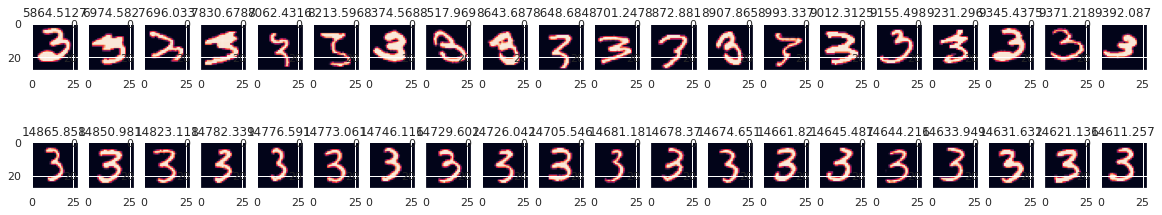

In [262]:
fig, ax = plt.subplots(2, 20, figsize=(20, 4))
for idx in range(20):
    ax[0][idx].imshow(class_wise_vanilla_x[class_idx][score_idx[idx]][0])
    ax[0][idx].set_title(label=score_samples[score_idx[idx]])
for idx in range(20):
    ax[1][idx].imshow(class_wise_vanilla_x[class_idx][score_idx[-idx-1]][0])
    ax[1][idx].set_title(label=score_samples[score_idx[-idx-1]])

In [263]:
def flip_labels(train_data, index_list, extra_class):
    flipped = []
    for i, (x, y) in enumerate(train_data):
#         print(index_list)
        if i in index_list:
            if extra_class > 0:
                y_ = 10#(y + 1) % 10
            else:
                y_ = (y + 1) % 10
        else:
            y_ = y
        flipped.append((x, y_))
    return flipped

def get_loaders(batch_size, indices, extra_class=0):
    transformations = transforms.Compose([transforms.ToTensor()])
    train_data = datasets.MNIST(root='/storage/sharan/datasets/mnist/', train=True, transform=transformations)
    test_data = datasets.MNIST(root='/storage/sharan/datasets/mnist/', train=False, transform=transformations)

    train_data = flip_labels(train_data, indices, extra_class=extra_class)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader
def poison_nonewclass_run(seed,flip_indices):
    flipped_tr_loader, flipped_te_loader = get_loaders(batch_size=BATCH_SIZE, indices=flip_indices, extra_class=0)
    torch.manual_seed(seed)
    flipped_model = get_model(extra_class=0)
    run = wandb.init(project='MNIST_components', config = {'train': 'poison',
                   'bs':BATCH_SIZE,
                   'lr':LR, 'seed':seed,
                    'extra_class':0,
                    'num_mislabelled':len(flip_indices),
                    'epochs':EPOCHS})
    # make optimizer and log

    fl_optimizer = torch.optim.Adam(flipped_model.parameters(), lr=LR)
    log = {
        'train_acc': [],
        'test_acc': [],
        'adv_acc': [],
        'loss': [],
     }
    wandb.watch(flipped_model, log='all')
    vanilla_train(EPOCHS, flipped_model, flipped_tr_loader, flipped_te_loader, fl_optimizer, log, eval_all=False)
    run.finish()
    return flipped_model
def poison_newclass_run(seed, flip_indices):
    flipped_tr_loader, flipped_te_loader = get_loaders(batch_size=BATCH_SIZE, indices=flip_indices, extra_class=1)
    torch.manual_seed(seed)
    flipped_model = get_model(extra_class=1)
    run = wandb.init(project='MNIST_components', config = {'train': 'poison',
                   'bs':BATCH_SIZE,
                   'lr':LR, 'seed':seed,
                    'extra_class':1,
                    'num_mislabelled':len(flip_indices),
                    'epochs':EPOCHS})
    # make optimizer and log

    fl_optimizer = torch.optim.Adam(flipped_model.parameters(), lr=LR)
    log = {
        'train_acc': [],
        'test_acc': [],
        'adv_acc': [],
        'loss': [],
     }
    wandb.watch(flipped_model, log='all')
    vanilla_train(EPOCHS, flipped_model, flipped_tr_loader, flipped_te_loader, fl_optimizer, log, eval_all=False)
    run.finish()
    return flipped_model

# Run many seeds for memorizing poisoned datasets

In [264]:
wandb.finish()
for poison_idx in range(-1):
    flip_indices = np.random.permutation(60000)[0:500]
    for run_idx in range(3):
        poison_nonewclass_run((1+99998776*run_idx)%617, flip_indices)
        poison_newclass_run((1+99998776*run_idx)%617, flip_indices)
# flipped_tr_loader, flipped_te_loader = get_loaders(batch_size=BATCH_SIZE, indices=flip_indices, extra_class=0)

In [265]:
flip_indices = np.random.permutation(60000)[0:500]
flipped_model_nonewclass = poison_nonewclass_run(1, flip_indices)

wandb: wandb version 0.11.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 14: 100%|██████████| 3750/3750 [00:07<00:00, 534.76it/s]
/homes/53/amartya/miniconda3/envs/sneaky/lib/python3.7/site-packages/ipykernel_launcher.py:168: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/IndexingUtils.h:30.)


loss,0.04462
_runtime,251
_timestamp,1627662015
_step,14
train_acc,0.99552
test_acc,0.9858
adv_acc,0.0


loss,▄▆▆▁▇█▁▁▁▂▁▄▁▂▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁
test_acc,▁
adv_acc,▁


In [266]:
def get_vulnerable_mask_with_adv(amodel, exclude_list=[]):
    '''
    Returns a boolean list over datapoints, specifying which ones are 
    vulnerable (True) and which ones are not (False)
    '''
    exclude_indices = np.where(exclude_list)
    res = []
    adv_ex_arr = []
    orig_ex_arr = []
    
    transformations = transforms.Compose([transforms.ToTensor()])
    train_data = datasets.MNIST(root='/storage/sharan/datasets/mnist/', train=True, transform=transformations)
    test_data = datasets.MNIST(root='/storage/sharan/datasets/mnist/', train=False, transform=transformations)
    
    train_data.data = np.delete(train_data.data, exclude_indices, axis=0)
    
        
    train_data.targets = np.delete(train_data.targets, exclude_indices, axis=0)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)

    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
    

    for x, y in tqdm(test_loader):
        x, y = x.cuda(), y.cuda()
        out, input = amodel(x, y, make_adv=True,
             constraint='inf', step_size=STEP_SIZE,
             eps=EPS, iterations=ITERATIONS, random_restarts=8,
                      targeted=False)
        out = torch.argmax(out, dim=-1) == y
        
        for idx,flags in enumerate(out):
            if flags <1:
                adv_ex_arr.append(input[idx])
                orig_ex_arr.append(x[idx])
        res.extend(out.cpu().detach().numpy())
        
    return res, adv_ex_arr, orig_ex_arr
def get_repr_from_x(iter_obj, model, latent_arr_idx=0):
    repr_arr = []
    for x in iter_obj:
        with torch.no_grad():
            latent = model.model(x.reshape(-1, 1, 28,28).cuda(), with_latent=True)[1][latent_arr_idx].squeeze().reshape(-1)
        repr_arr.append(latent.detach().cpu().numpy())
    return repr_arr

In [272]:
flipped_mask, flipped_adv_exs, pre_flip_adv = get_vulnerable_mask_with_adv(flipped_model_nonewclass, [])#np.where(vanilla_mask)) #vulnerable examples of flipped model
class_wise_flipped_mask = split_dataset(flipped_mask, test_data) #classwise division (indices) of vulnerable examples
flipped_x_vul = split_dataset_x(flipped_mask, test_data) #actual data that are adv vulnerable

100%|██████████| 79/79 [00:34<00:00,  2.28it/s]


In [273]:
noise_mask = list(map(lambda x: 0 if x not in flip_indices else 1, range(len(train_data)))) # mask for which examples are flipped
non_noise_mask = list(map(lambda x: 1 if x not in flip_indices else 0, range(len(train_data)))) # mask for which examples are not flipped
flipped_x_vul = split_dataset_x(noise_mask, train_data) #actual data whose label are flipped

In [274]:
adv_repr = get_repr_from_x(flipped_adv_exs, flipped_model_nonewclass, latent_arr_idx=1) #representations for adv
pre_att_adv_repr = get_repr_from_x(pre_flip_adv, flipped_model_nonewclass, latent_arr_idx=1) #representation of adv examples before attack
noise_repr = get_repr(noise_mask, train_data, flipped_model_nonewclass, latent_arr_idx=1) #representations for label noise
clean_repr = get_repr(non_noise_mask, train_data, flipped_model_nonewclass, latent_arr_idx=1) #representations for label noise

In [275]:
def stack_arrays(arr):
    arr_ = []
    for ll in arr:
        if len(ll) > 0:
            arr_.append(np.stack(ll))
    return arr_

X = stack_arrays(noise_repr)#[np.stack(x) if len(x)>0 for x in noise_repr]
X = np.vstack(X)
print(X.shape)
noisy_pca = PCA(n_components=64) # PC of noise examples
noisy_pca.fit(X)

X = stack_arrays(clean_repr)#[np.stack(x) for x in clean_repr]
X = np.vstack(X)
print(X.shape)
non_noisy_pca = PCA(n_components=64) # PC of noise examples
non_noisy_pca.fit(X)

# import matplotlib.pyplot as plt
# score_samples = pca.score_samples(X)
# score_idx = np.argsort(score_samples)

(500, 9216)
(59500, 9216)


PCA(n_components=64)

In [276]:
noise_repr_concat = np.vstack(stack_arrays(noise_repr))#[np.stack(x) for x in noise_repr])
clean_repr_concat = np.vstack(stack_arrays(clean_repr))[:-2000]#[np.stack(x) for x in clean_repr])
sim_fn = lambda x,z : np.dot(x,z)#/(np.linalg.norm(x)*np.linalg.norm(z)) 
diff_repr = np.vstack(stack_arrays(clean_repr))[-2000:]#np.asarray(adv_repr)-np.asarray(pre_att_adv_repr)
diff_repr_adv = np.asarray(adv_repr)#-np.asarray(pre_att_adv_repr)
# diff_repr = np.asarray(pre_att_adv_repr)

In [282]:
diff_repr.shape, noise_repr_concat.shape, flipped_model_nonewclass





((2000, 9216),
 (500, 9216),
 AttackerModel(
   (model): MNIST_model(
     (layers1): Sequential(
       (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
       (1): ReLU()
     )
     (layers2): Sequential(
       (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
       (1): ReLU()
       (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
       (3): Flatten(start_dim=1, end_dim=-1)
     )
     (fc1): Linear(in_features=9216, out_features=128, bias=True)
     (fc2): Linear(in_features=128, out_features=10, bias=True)
   )
   (attacker): Attacker(
     (model): MNIST_model(
       (layers1): Sequential(
         (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
         (1): ReLU()
       )
       (layers2): Sequential(
         (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
         (1): ReLU()
         (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (3): Flatten(start_dim=1, end_dim=-1)
      

10000


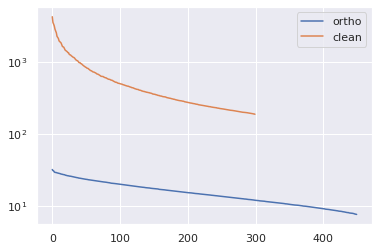

In [278]:
non_noisy_pca = PCA(n_components=300, whiten=False) # PC of noise examples
non_noisy_pca.fit(clean_repr_concat[:-2500])
random_set = clean_repr_concat[-2500:]
orthogonal_sub = noise_repr_concat - non_noisy_pca.inverse_transform(non_noisy_pca.transform(noise_repr_concat))
# orthogonal_sub = random_set - non_noisy_pca.inverse_transform(non_noisy_pca.transform(random_set))
orthogonal_pca = PCA(n_components=450, whiten=False)


orthogonal_pca.fit(orthogonal_sub)

print(len(adv_repr))
plt.plot(orthogonal_pca.singular_values_, label='ortho')
plt.plot(non_noisy_pca.singular_values_, label='clean')
plt.legend()
plt.yscale('log')

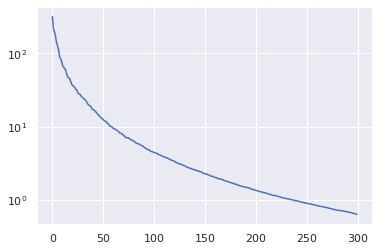

In [279]:
plt.plot(non_noisy_pca.explained_variance_)
plt.yscale('log')

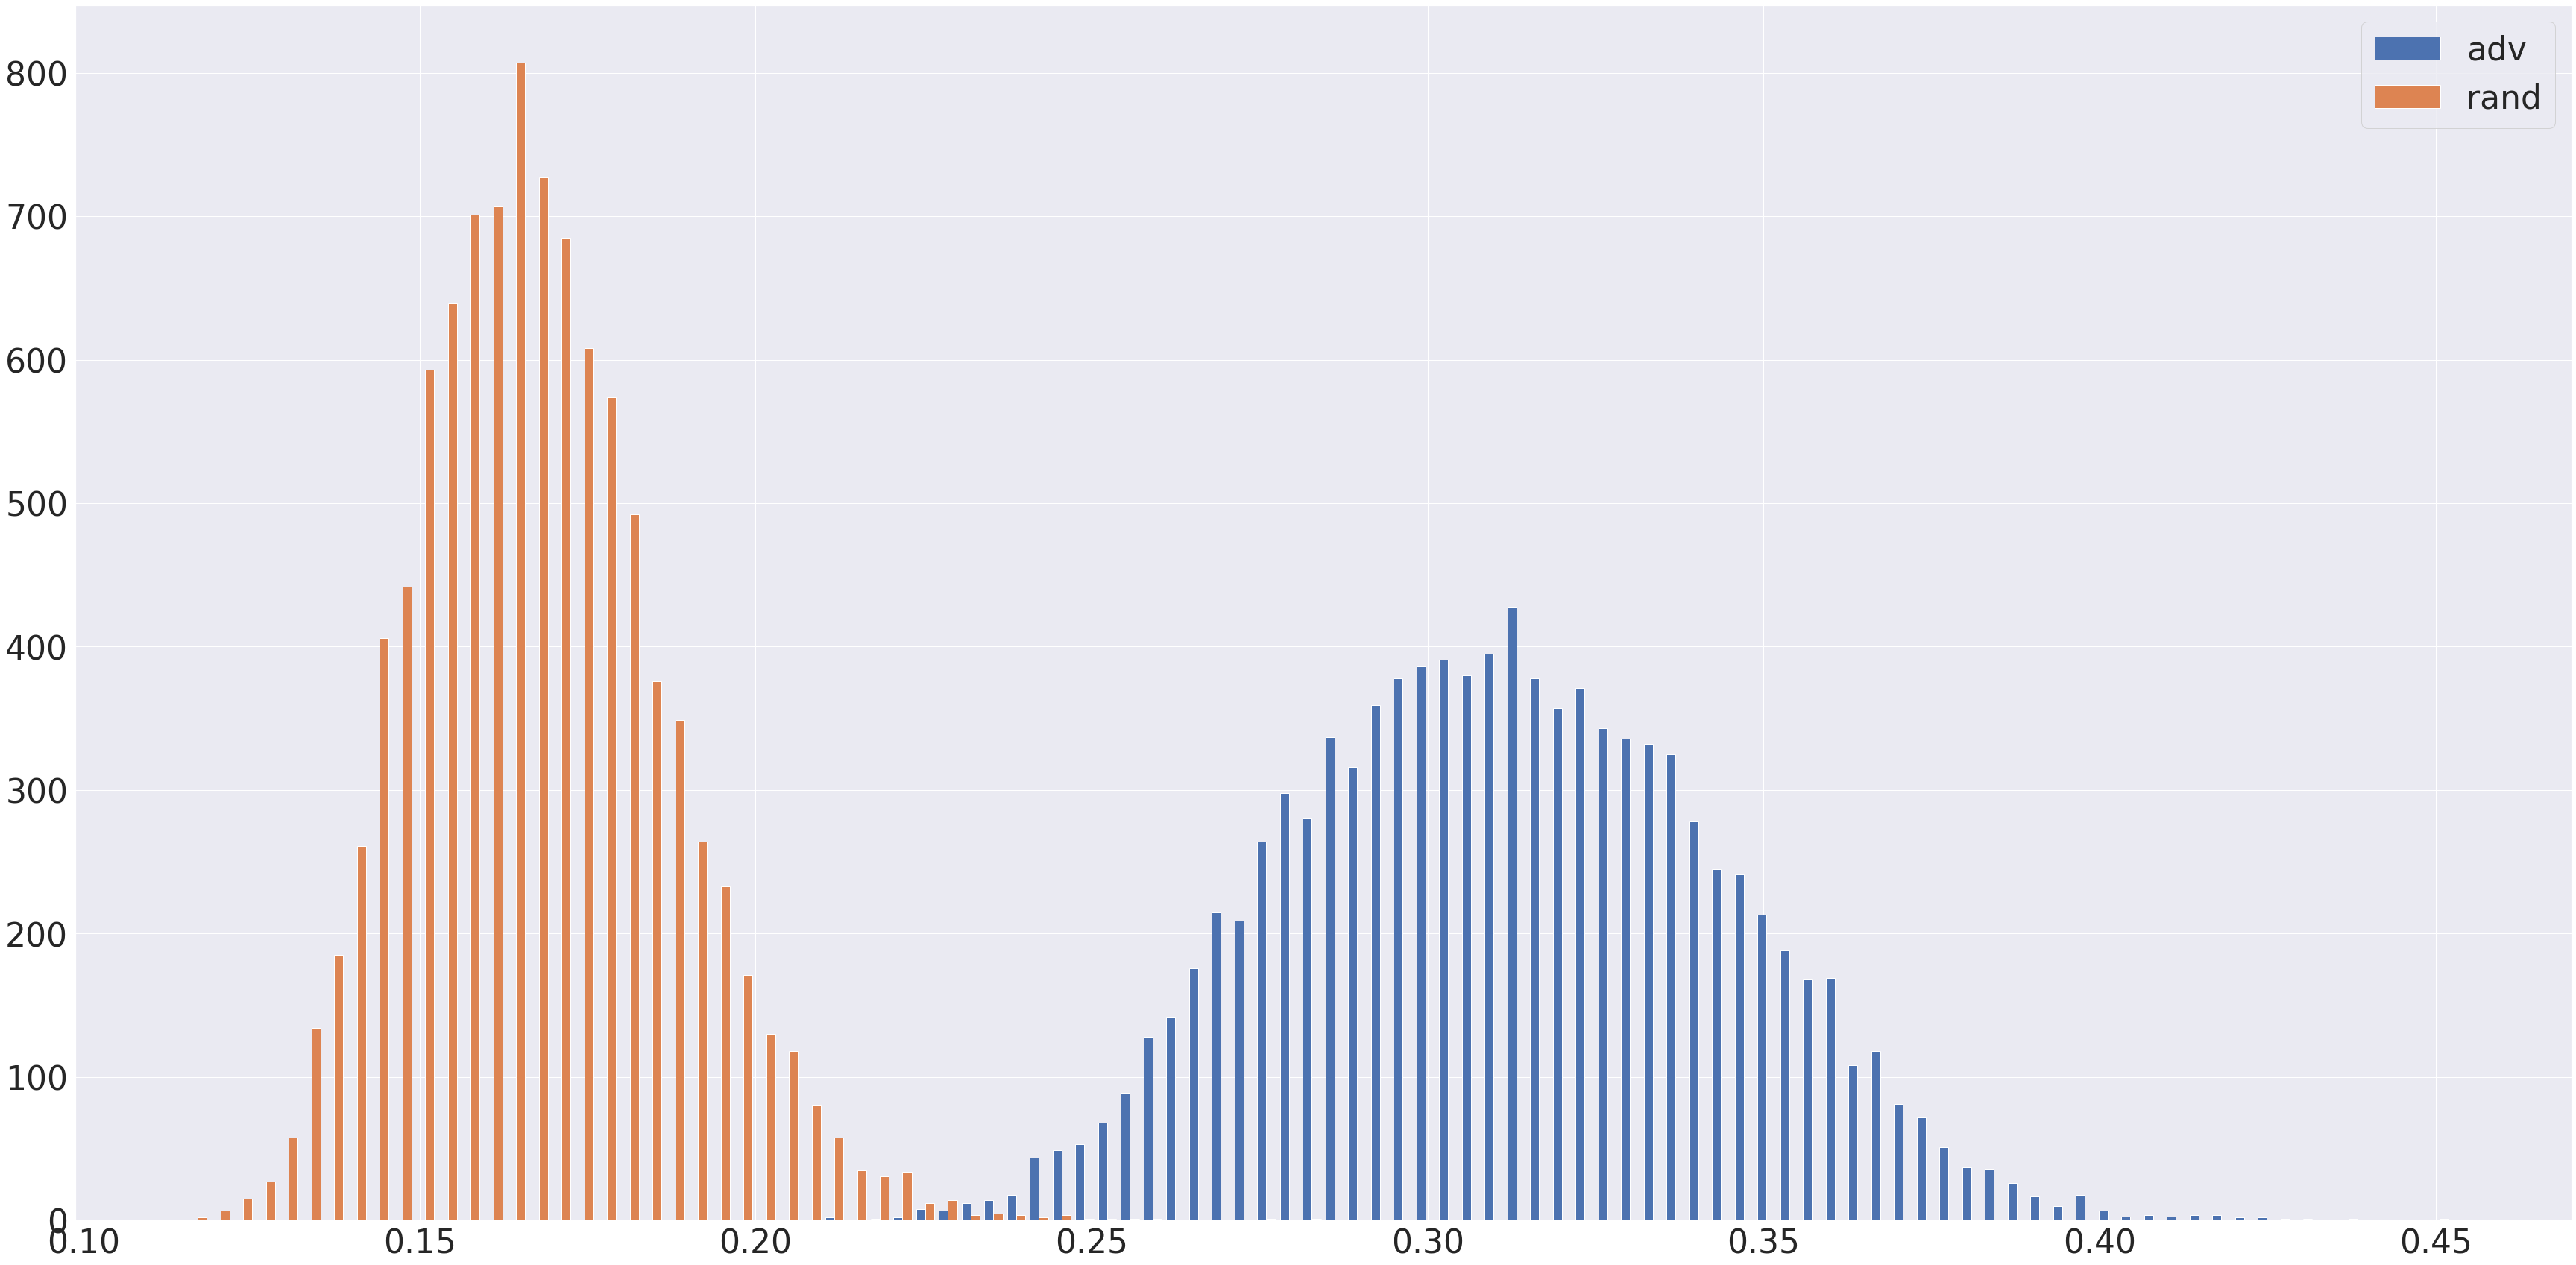

In [280]:
plt.figure(figsize=(60,30))
ratio_energy_spaces_adv = np.linalg.norm(orthogonal_pca.transform(adv_repr), axis=1)/np.linalg.norm(non_noisy_pca.transform(adv_repr), axis=1)
ratio_energy_spaces_rand = np.linalg.norm(orthogonal_pca.transform(pre_att_adv_repr), axis=1)/np.linalg.norm(non_noisy_pca.transform(pre_att_adv_repr), axis=1)
plt.hist(bins=100, x=[ratio_energy_spaces_adv, ratio_energy_spaces_rand], label=['adv', 'rand'])
# plt.xscale('log')
plt.legend(fontsize=44)
plt.xticks(fontsize=44)
_=plt.yticks(fontsize=44)

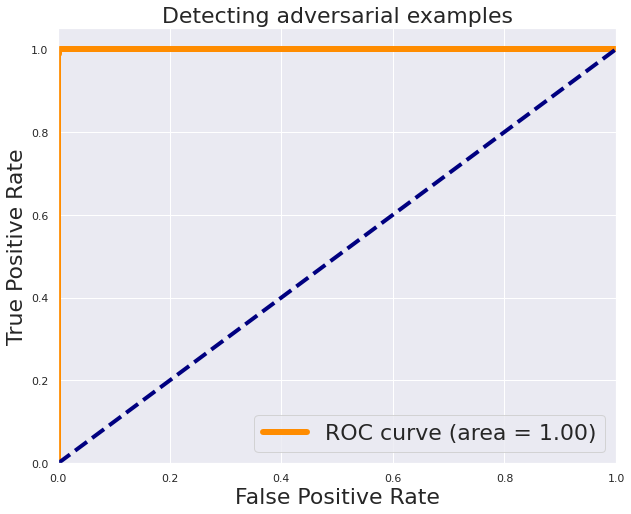

In [281]:
import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(np.concatenate([np.ones_like(ratio_energy_spaces_adv), np.zeros_like(ratio_energy_spaces_rand)]),
                                         np.concatenate([ratio_energy_spaces_adv,ratio_energy_spaces_rand]) , 
                                         )
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='darkorange',linewidth=6, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linewidth=4, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('Detecting adversarial examples', fontsize=22)
plt.legend(loc="lower right", fontsize=22)
plt.show()

In [ ]:
import numpy as np
from sklearn import metrics
# wandb.finish()
def get_classification_auc(clean_comps=100, ortho_dim=100, visualize=False):
#     run = wandb.init(project='MNIST_components', entity='robpeop', config={"clean_comps":clean_comps, "ortho_dim":ortho_dim, 'layer_Id':0})
    non_noisy_pca = PCA(n_components=clean_comps, whiten=False) # PC of noise examples
    non_noisy_pca.fit(clean_repr_concat[:-2500])
    random_set = clean_repr_concat[-2500:]
    orthogonal_sub = noise_repr_concat - non_noisy_pca.inverse_transform(non_noisy_pca.transform(noise_repr_concat))
    # orthogonal_sub = random_set - non_noisy_pca.inverse_transform(non_noisy_pca.transform(random_set))
    orthogonal_pca = PCA(n_components=ortho_dim, whiten=False)
    orthogonal_pca.fit(orthogonal_sub)

    if visualize:
        print(len(adv_repr))
        plt.plot(orthogonal_pca.singular_values_, label='ortho')
        plt.plot(non_noisy_pca.singular_values_, label='clean')
        plt.legend()
        plt.yscale('log')
        plt.show()
    ratio_energy_spaces_adv = np.asarray([np.linalg.norm(orthogonal_pca.transform([adv_repr[idx]]))/np.linalg.norm(non_noisy_pca.transform([adv_repr[idx]])) for idx in range(len(adv_repr))])
    ratio_energy_spaces_rand = np.asarray([np.linalg.norm(orthogonal_pca.transform([pre_att_adv_repr[idx]]))/ np.linalg.norm(non_noisy_pca.transform([pre_att_adv_repr[idx]])) for idx in range(len(adv_repr))])
    if visualize:
        plt.figure(figsize=(60,30))
        plt.hist(bins=100, x=[ratio_energy_spaces_adv, ratio_energy_spaces_rand], label=['adv', 'rand'])
        # plt.xscale('log')
        plt.legend(fontsize=44)
        plt.xticks(fontsize=44)
        _=plt.yticks(fontsize=44)
    fpr, tpr, thresholds = metrics.roc_curve(np.concatenate([np.ones_like(ratio_energy_spaces_adv), np.zeros_like(ratio_energy_spaces_rand)]),
                                         np.concatenate([ratio_energy_spaces_adv,ratio_energy_spaces_rand]) , 
                                         )
    roc_auc = metrics.auc(fpr, tpr)
    if visualize:
        plt.figure(figsize=(10,8))
        plt.plot(fpr, tpr, color='darkorange',linewidth=6, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linewidth=4, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=22)
        plt.ylabel('True Positive Rate', fontsize=22)
        plt.title('Detecting adversarial examples', fontsize=22)
        plt.legend(loc="lower right", fontsize=22)
        plt.show()

#     wandb.log({"auc": roc_auc})
#     run.finish()
    return roc_auc

auc_arr = [get_classification_auc(clean_comps=x, ortho_dim=180, visualize=True) for x in np.arange(40,100,10)]

In [ ]:
plt.plot(np.arange(40,100,10), auc_arr)

In [ ]:
# import wandb

# sweep_config = {
#   "name" : "roc_sweep_layer2",
#   "method" : "bayes",
#   "metric" : {"name":"auc", "goal":"maximize"},
#   "parameters" : {
#     "clean_comps" : {
#       "min" : 100,
#         "max": 1152
#     },
#     "ortho_dim" :{
#       "min" : 100,
#         "max": 1152
#     }
#   }
# }

# sweep_id = wandb.sweep(sweep_config)
# count=50
# wandb.agent(sweep_id, function=get_classification_auc, count=count)

In [ ]:
plt.figure(figsize=(60,30))
plt.hist(bins=100, x=[projection_values_ortho, projection_values_clean], label=['noisy', 'clean'])
# plt.xscale('log')
plt.legend(fontsize=44)
plt.xticks(fontsize=44)
_=plt.yticks(fontsize=44)

In [ ]:
plt.figure(figsize=(60,30))
plt.hist(bins=100, x=[rand_projection_values_ortho, rand_projection_values_clean, ], label=['noisy', 'clean', ])
# plt.xscale('log')
plt.legend(fontsize=44)
plt.xticks(fontsize=44)
_=plt.yticks(fontsize=44)

In [ ]:
plt.figure(figsize=(60,30))
plt.hist(bins=100, x=[projection_values_ortho, projection_values_clean, pre_projection_values_ortho, pre_projection_values_clean], label=['noisy', 'clean', 'noisy_pre', 'clean_pre'])
# plt.xscale('log')
plt.legend(fontsize=44)
plt.xticks(fontsize=44)
_=plt.yticks(fontsize=44)

In [ ]:
plt.plot(projection_values_ortho/pre_projection_values_ortho)
plt.plot(projection_values_clean/pre_projection_values_clean)

In [ ]:
# _ = plt.hist(bins=100, x=projection_values_clean, label='clean')
_ = plt.hist(bins=50, x=[projection_values_clean, projection_values_adv,], 
             label=['adv', 'clean'], histtype='step', density=False)
plt.yscale('log')
plt.legend()

In [ ]:
plt.plot(orthogonal_sub[0])

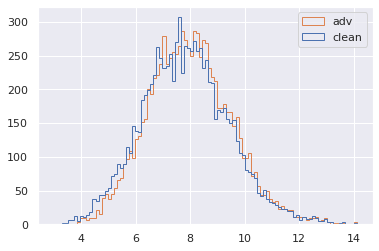

In [232]:
noise_ex = get_x(noise_mask, train_data, ) #examples for label noise
clean_ex = get_x(non_noise_mask, train_data, ) #examples for no label noise

noise_ex_concat = np.vstack([np.stack(x) for x in noise_ex])
clean_ex_concat = np.vstack([np.stack(x) for x in clean_ex])

non_noisy_ex_pca = PCA(n_components=400) # PC of noise examples
non_noisy_ex_pca.fit(clean_ex_concat)

orthogonal_sub_ex = clean_ex_concat - non_noisy_ex_pca.inverse_transform(non_noisy_ex_pca.transform(clean_ex_concat))
orthogonal_ex_pca = PCA(n_components=500)
orthogonal_ex_pca.fit(orthogonal_sub_ex)

projection_values_ex_clean = [np.linalg.norm(orthogonal_ex_pca.transform([pre_flip_adv[idx].reshape(-1).cpu().numpy()])) for idx in range(len(pre_flip_adv))]
projection_values_ex_adv = [np.linalg.norm(orthogonal_ex_pca.transform([flipped_adv_exs[idx].reshape(-1).cpu().numpy()])) for idx in range(len(flipped_adv_exs))]

_ = plt.hist(bins=100, x=[projection_values_ex_clean, projection_values_ex_adv,], label=['clean', 'adv'], histtype='step', density=False)
#plt.yscale('log')
plt.legend()

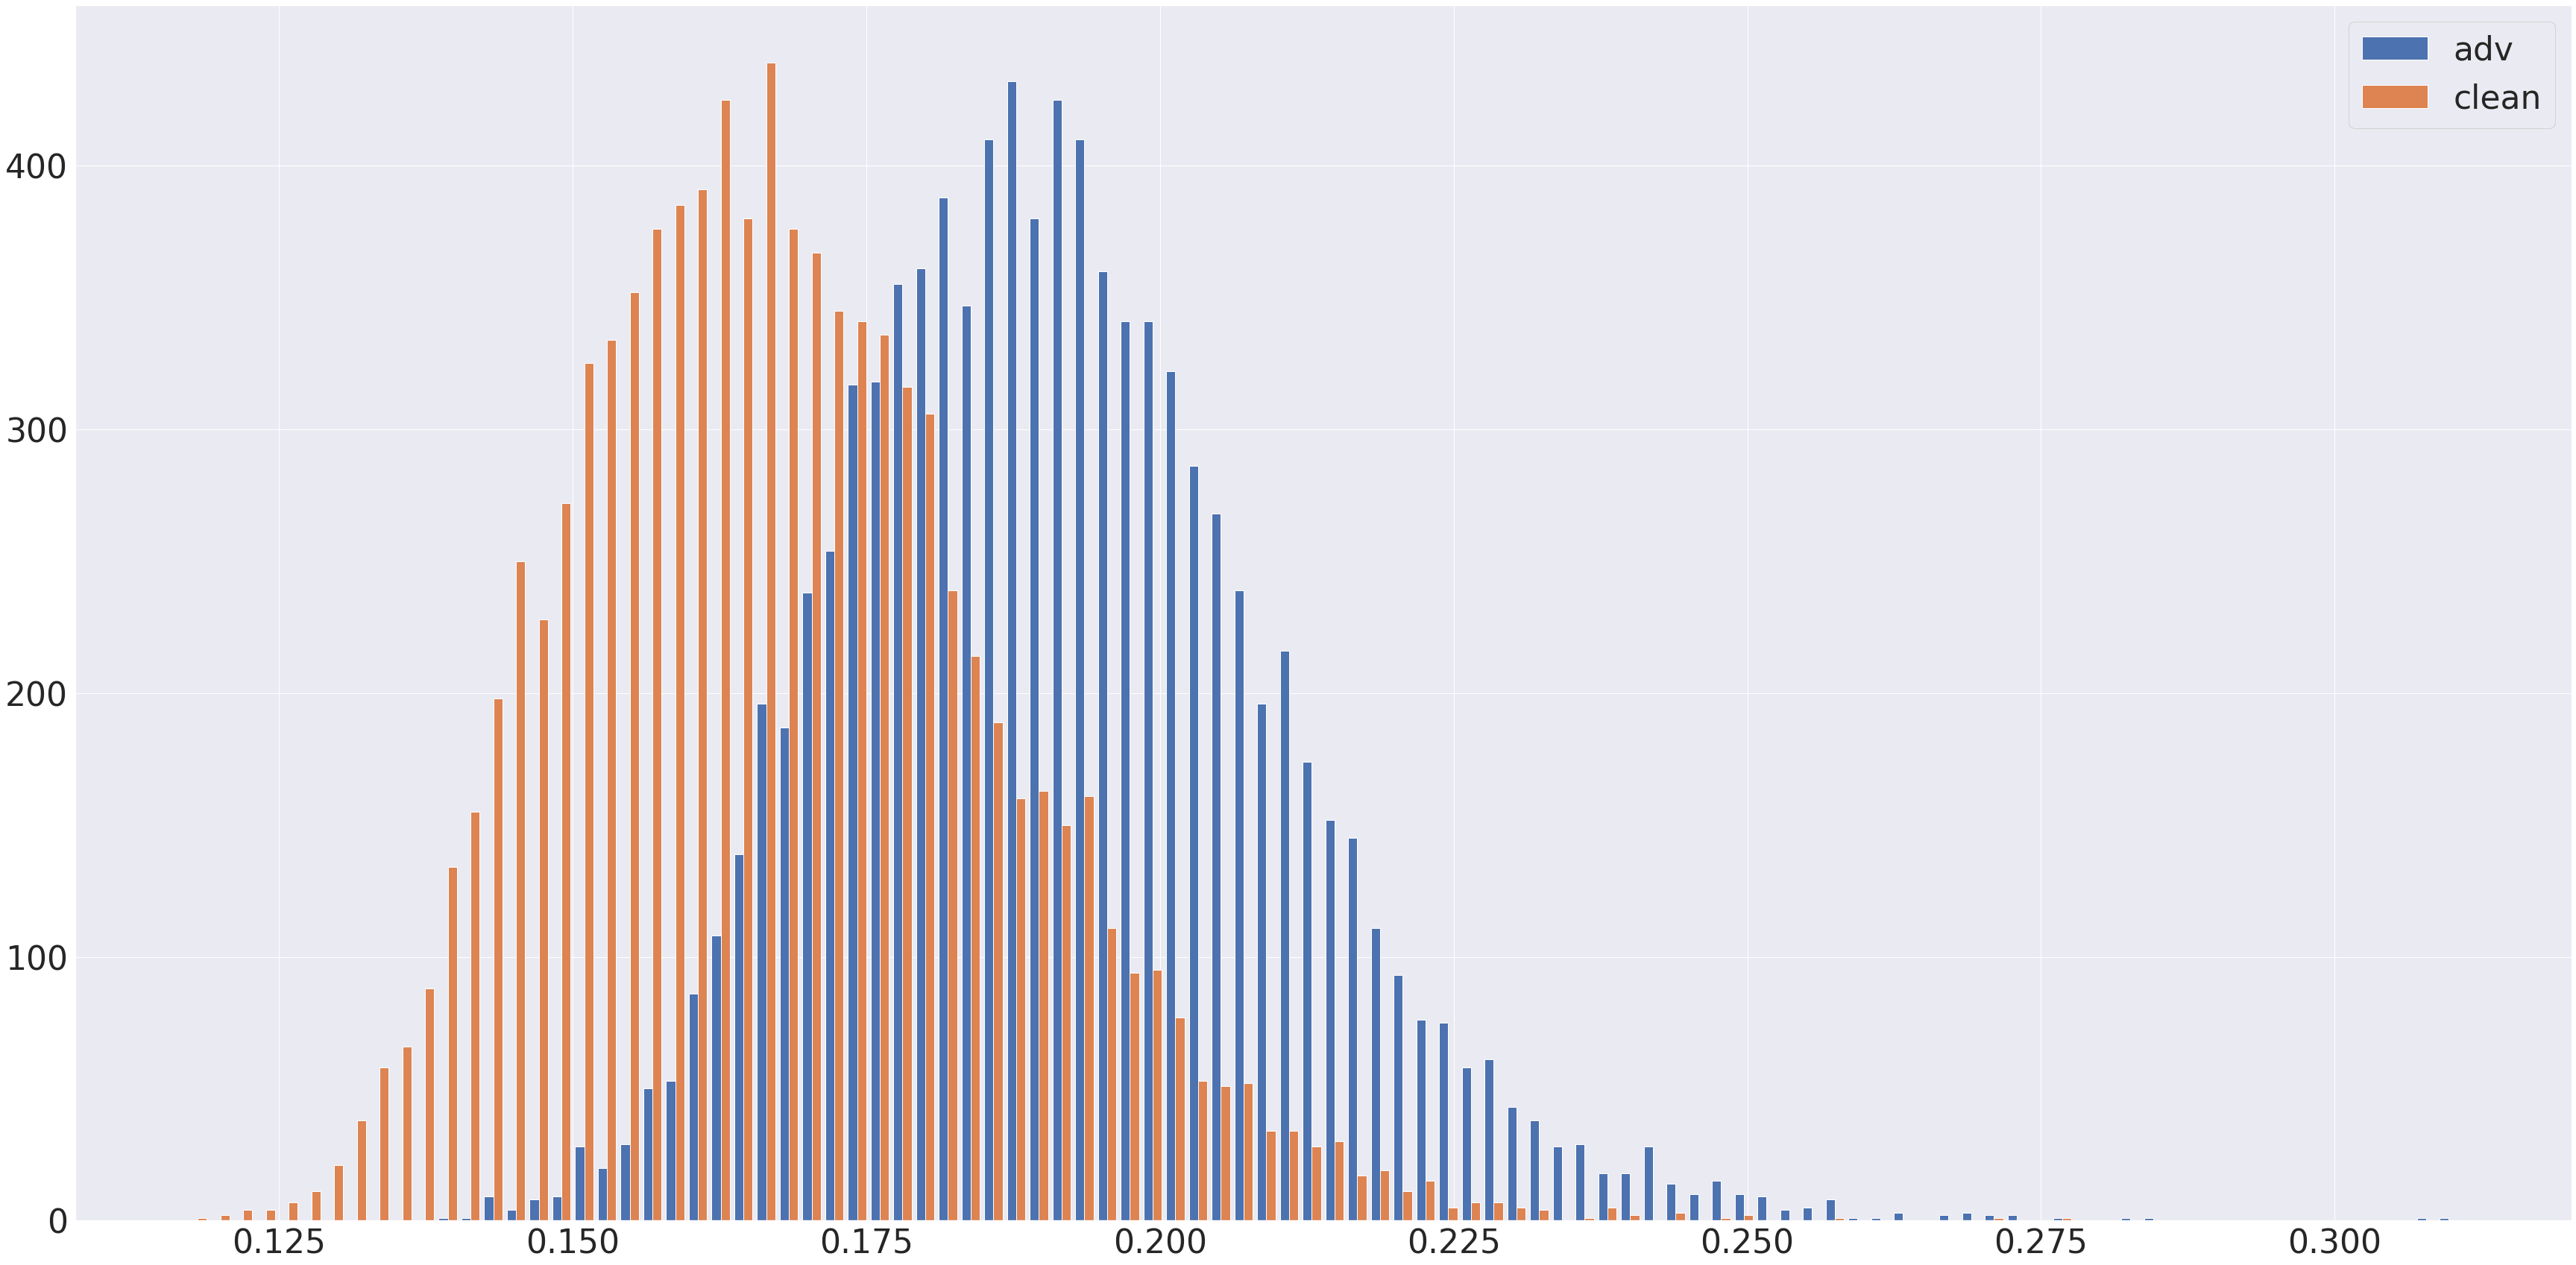

In [233]:
ratio_energy_spaces_adv_ex = np.asarray([np.linalg.norm(orthogonal_ex_pca.transform([flipped_adv_exs[idx].reshape(-1).cpu().numpy()]))/np.linalg.norm(non_noisy_ex_pca.transform([flipped_adv_exs[idx].reshape(-1).cpu().numpy()])) for idx in range(len(flipped_adv_exs))])
ratio_energy_spaces_rand_ex = np.asarray([np.linalg.norm(orthogonal_ex_pca.transform([pre_flip_adv[idx].reshape(-1).cpu().numpy()]))/ np.linalg.norm(non_noisy_ex_pca.transform([pre_flip_adv[idx].reshape(-1).cpu().numpy()])) for idx in range(len(flipped_adv_exs))])
plt.figure(figsize=(60,30))
plt.hist(bins=100, x=[ratio_energy_spaces_adv, ratio_energy_spaces_rand], label=['adv', 'clean'])
# plt.xscale('log')
plt.legend(fontsize=44)
plt.xticks(fontsize=44)
_=plt.yticks(fontsize=44)


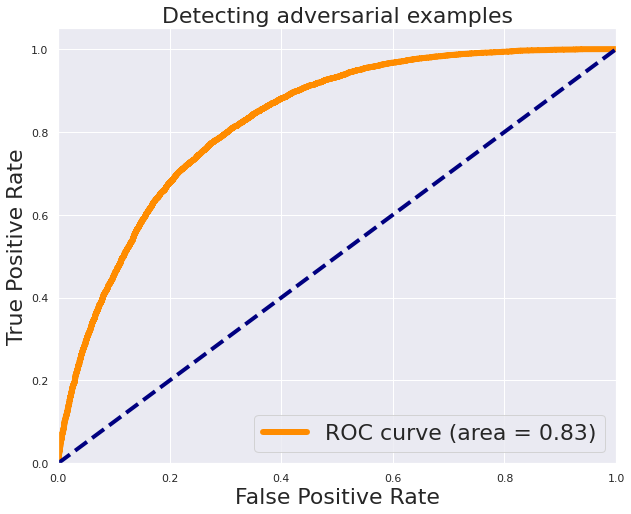

In [235]:
import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(np.concatenate([np.ones_like(ratio_energy_spaces_adv_ex), np.zeros_like(ratio_energy_spaces_rand_ex)]),
                                         np.concatenate([ratio_energy_spaces_adv,ratio_energy_spaces_rand]) , 
                                         )
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='darkorange',linewidth=6, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linewidth=4, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('Detecting adversarial examples', fontsize=22)
plt.legend(loc="lower right", fontsize=22)
plt.show()

In [ ]:
metrics.auc(fpr, tpr)

In [250]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)
pgd_eval(model, test_loader)

/homes/53/amartya/miniconda3/envs/sneaky/lib/python3.7/site-packages/ipykernel_launcher.py:168: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/IndexingUtils.h:30.)


0.0